# An In-depth Exploration of Climate Change Projections and Their Potential Effects On Four Vital Crops Worldwide

## Project Goal
Crop production in different regions is affected by different factors, and what crop should be grown for good result

In [2]:
# Drive the mount
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0bb8de1c363cbbd7280c91086f1e5d08f3b83ecb7f0d35b2b770676aaf88d094
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Import necessary libraries

In [4]:
#Import the necessary file
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Load Data Set

In [5]:
# Give the file path
path = "/content/drive/MyDrive/Bigdata/try/Projected_impacts.csv"

In [6]:
spark = SparkSession.builder.appName("Crop Production").getOrCreate()

In [7]:
#Read the file using spark
df = spark.read.option("header", "true").option("inferSchema","true").csv(path)
df.show()

+---+-------+----------------+--------+-----+-------------+--------------+-------------+--------+---------+----------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------------------------------------+----------------+------------------+----------+----------------+---------------+--------------+-----------------------+---------------------------------------------+--------------------------------------------+------------------------------------------+------------------------+----------------------+-------------------+--------------------------------+--------------------------+------------------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+------+----------+---------------+--------------------+--------------------+----------------+-----+-----+-----+-----+----------------------------------------------------------------+---

## Exploratory Data Analysis(EDA)/ Data Preprocessing

In [8]:
#See the shape of the file
num_rows = df.count()
columns = df.columns
num_columns = len(columns)
print(f"Number of rows and columns is ({num_rows},{num_columns})")
print("Column names:", columns)

Number of rows and columns is (8707,52)
Column names: ['ID', 'Ref No ', ' Methods', 'Scale', 'Crop', 'Country', 'Site(location)', 'Region', 'latitude', 'longitude', 'Current Average Temperature (dC)_area_weighted', 'Current Average Temperature_point_coordinate (dC)', 'Current Annual Precipitation (mm) _area_weighted ', 'Current Annual Precipitation  (mm) _point_coordinate', 'Future_Mid-point', 'Baseline_Mid-point', 'Time slice', 'Climate scenario', 'Scenario source', 'Local delta T ', 'Local delta T from 2005', 'Annual Precipitation change each study  (mm) ', ' Annual Precipitation change  from 2005 (mm)', 'Global delta T from pre-industrial period ', 'Global delta T from 2005', 'Projected yield (t/ha)', 'Climate impacts (%)', 'Climate impacts relative to 2005', 'Climate impacts per dC (%)', 'Climate impacts per decade (%)', 'CO2', 'CO2 ppm', 'Fertiliser', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage', 'Others', 'Adaptation', 'Adaptation type', 

### Get The statistical Information of Numerical Columns

In [9]:
summary = df.describe()
summary.show()

+-------+--------------------+------------------+----------------+--------------------+-----+-------+--------------+-------------+------------------+-----------------+----------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------------------------------------+------------------+------------------+----------+--------------------+---------------+------------------+-----------------------+---------------------------------------------+--------------------------------------------+------------------------------------------+------------------------+----------------------+-------------------+--------------------------------+--------------------------+------------------------------+----+------------------+----------+----------+--------+------------------------------+-------------+-------+------+----------+---------------+--------------------+--------------------+------------------+-----+--

In [10]:
# Get the information of dataframe
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Ref No : string (nullable = true)
 |--  Methods: string (nullable = true)
 |-- Scale: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Site(location): string (nullable = true)
 |-- Region: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Current Average Temperature (dC)_area_weighted: double (nullable = true)
 |-- Current Average Temperature_point_coordinate (dC): double (nullable = true)
 |-- Current Annual Precipitation (mm) _area_weighted : double (nullable = true)
 |-- Current Annual Precipitation  (mm) _point_coordinate: double (nullable = true)
 |-- Future_Mid-point: double (nullable = true)
 |-- Baseline_Mid-point: integer (nullable = true)
 |-- Time slice: string (nullable = true)
 |-- Climate scenario: string (nullable = true)
 |-- Scenario source: string (nullable = true)
 |-- Local delta T : double (nullable = true)

In [11]:
# Count the number of null value present in dataframe
null_counts = [spark_sum(col(column).isNull().cast("int")).alias(column) for column in columns]
# Calculate the number of null values
null_counts_result = df.select(null_counts)
# Show the result
null_counts_result.show()

+---+-------+--------+-----+----+-------+--------------+------+--------+---------+----------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------------------------------------+----------------+------------------+----------+----------------+---------------+--------------+-----------------------+---------------------------------------------+--------------------------------------------+------------------------------------------+------------------------+----------------------+-------------------+--------------------------------+--------------------------+------------------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+------+----------+---------------+---------+---+----------------+-----+-----+-----+-----+----------------------------------------------------------------+----------------------------------------------------+---

### Handling Missing Value
Visulize null or Missing Value

<Axes: >

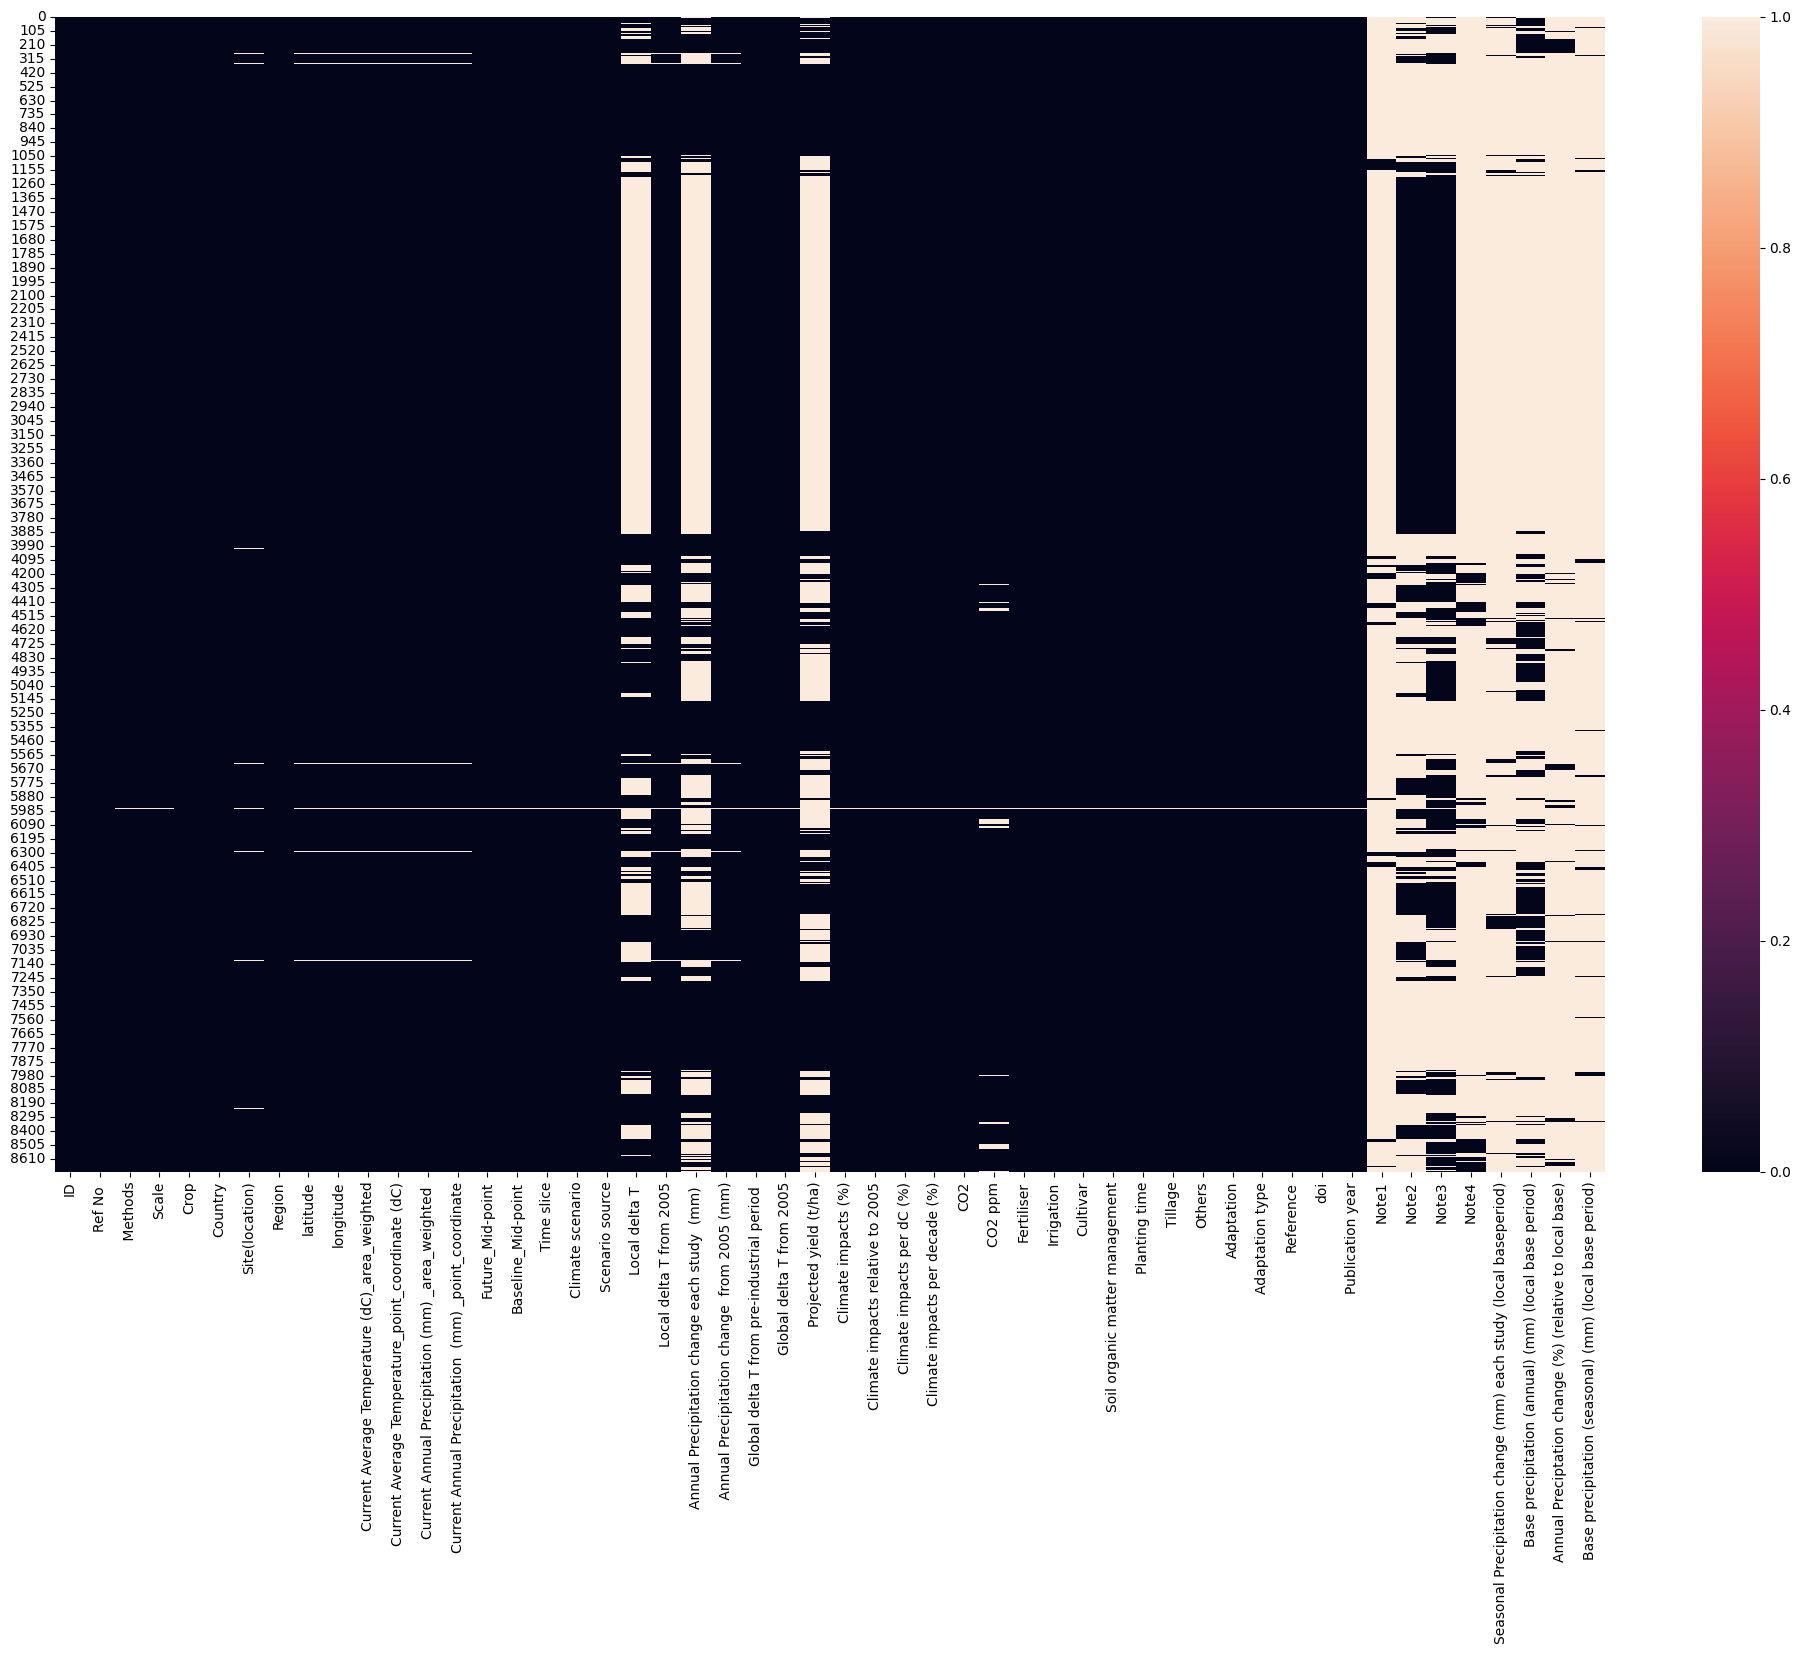

In [12]:
df_pandas = df.toPandas()
plt.figure(figsize = (25,15))
sns.heatmap(df_pandas.isnull())

##This heatmap displays our dataset in a visual way. Each column represents a feature, and each row represents a data point. White cells represent missing values and help us identify areas of missing data.

### Getting null value of every column in percentage

In [13]:
#Getting the null value
null_percentage = (df_pandas.isnull().sum() / len(df_pandas)) * 100
null_percentage

ID                                                                   0.000000
Ref No                                                               0.000000
 Methods                                                             0.045940
Scale                                                                0.045940
Crop                                                                 0.000000
Country                                                              0.000000
Site(location)                                                       0.562766
Region                                                               0.000000
latitude                                                             0.470885
longitude                                                            0.470885
Current Average Temperature (dC)_area_weighted                       0.470885
Current Average Temperature_point_coordinate (dC)                    0.470885
Current Annual Precipitation (mm) _area_weighted                

In [14]:
feature_selection = [
    'Crop', 'Region', 'Current Average Temperature (dC)_area_weighted',
    'Current Annual Precipitation (mm) _area_weighted ', 'Local delta T ',
    'Annual Precipitation change each study  (mm) ',
    'Projected yield (t/ha)', 'Climate impacts (%)', 'CO2', 'CO2 ppm',
    'Fertiliser', 'Irrigation', 'Cultivar',
    'Soil organic matter management', 'Planting time', 'Tillage',
    'Adaptation', 'Adaptation type', 'Publication year'
]

In [15]:
dataframe = df.select(*feature_selection)
dataframe.show()

+-----+-------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
| Crop|       Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+-----+-------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+---------

In [16]:
null_counts = [spark_sum(col(column).isNull().cast("int")).alias(column) for column in dataframe.columns]
null_counts_df = dataframe.select(null_counts)
null_counts_df.show()

+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
|Crop|Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+--

In [17]:
# Remove the rows with respective to null value present in Porjected yield
dataframe = dataframe.na.drop(subset=["Projected yield (t/ha)"])

In [18]:
dataframe.show()

+-----+-------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
| Crop|       Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+-----+-------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+---------

In [19]:
num_rows = dataframe.count()
columns = dataframe.columns
num_columns = len(columns)
print(f"Number of rows and columns is ({num_rows},{num_columns})")
print("Column names:", columns)

Number of rows and columns is (3420,19)
Column names: ['Crop', 'Region', 'Current Average Temperature (dC)_area_weighted', 'Current Annual Precipitation (mm) _area_weighted ', 'Local delta T ', 'Annual Precipitation change each study  (mm) ', 'Projected yield (t/ha)', 'Climate impacts (%)', 'CO2', 'CO2 ppm', 'Fertiliser', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage', 'Adaptation', 'Adaptation type', 'Publication year']


## Data visualisation

As we cannot do the visulation with the spark dataframe we have to convert into pandas dataframe




In [20]:
data = dataframe.toPandas()

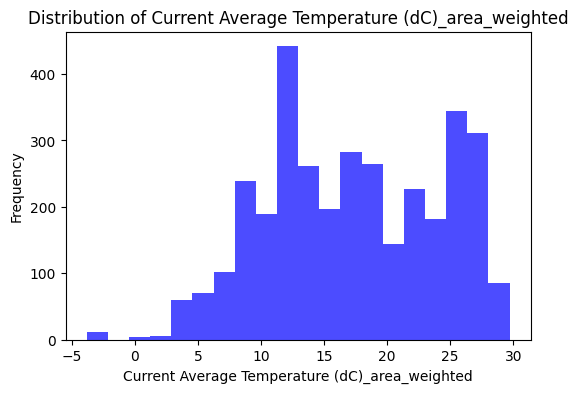

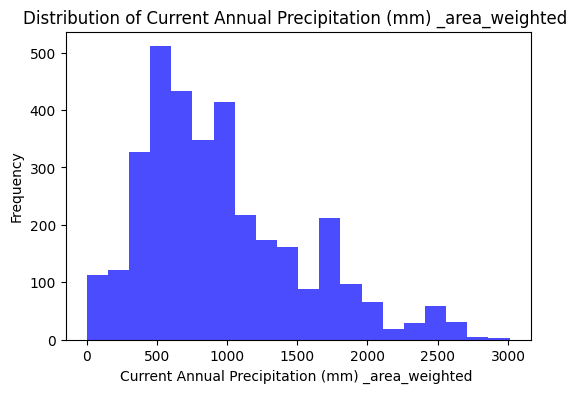

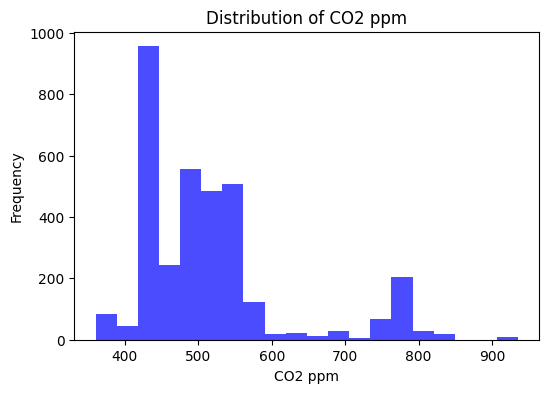

In [21]:
# Histogram plot of Current Average Temperature (dC)_area_weighted and Current Annual Precipitation (mm) _area_weighted
numeric_column = ['Current Average Temperature (dC)_area_weighted', 'Current Annual Precipitation (mm) _area_weighted ', 'CO2 ppm']
for column in numeric_column:
    plt.figure(figsize=(6, 4))
    plt.hist(data[column], bins=20, color='blue', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.show()

##This code generates histogram plots to visualize the distribution of numeric data in three specific columns: 'Current Average Temperature (dC)_area_weighted,' 'Current Annual Precipitation (mm) _area_weighted,' and 'CO2 ppm.'  In the histogram, the x-axis represents the data values grouped into bins, and the y-axis represents the frequency or count of data.

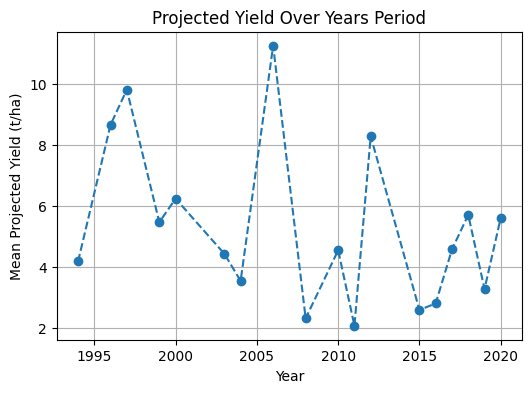

In [22]:
# Select the columns
select_year_yeild = ['Publication year', 'Projected yield (t/ha)']
# Group the selected_year_yeild by publication year and finding the mean of Projected yeild
year_yeild = data[select_year_yeild].groupby('Publication year').mean()
# Create the line plot to determine the change the project yeild over the time period
plt.figure(figsize=(6, 4))
plt.plot(year_yeild.index, year_yeild['Projected yield (t/ha)'], marker='o', linestyle='--')
plt.title('Projected Yield Over Years Period')
plt.xlabel('Year')
plt.ylabel('Mean Projected Yield (t/ha)')
plt.grid(True)
plt.show()

##This line plot illustrates the change in mean projected yield (in metric tons per hectare) over a period of time, with years on the x-axis and the yield values on the y-axis.

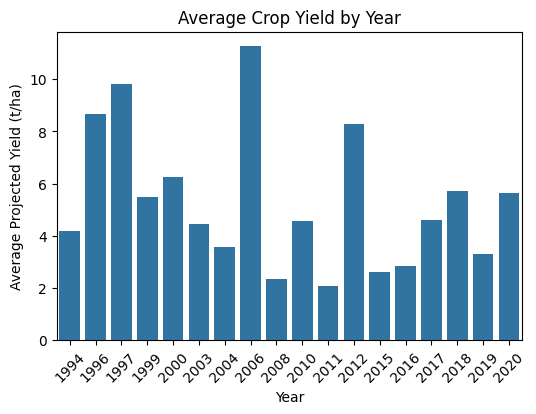

In [23]:
yearly_data = data.groupby('Publication year')['Projected yield (t/ha)'].mean().reset_index()
plt.figure(figsize=(6, 4))
plt.title('Average Crop Yield by Year')
sns.barplot(x='Publication year', y='Projected yield (t/ha)', data=yearly_data)
plt.xlabel('Year')
plt.ylabel('Average Projected Yield (t/ha)')
plt.xticks(rotation=45)
plt.show()

##This bar plot shows the average crop yield (in metric tons per hectare) for each year. Each bar represents a year, and its height indicates the average projected yield.

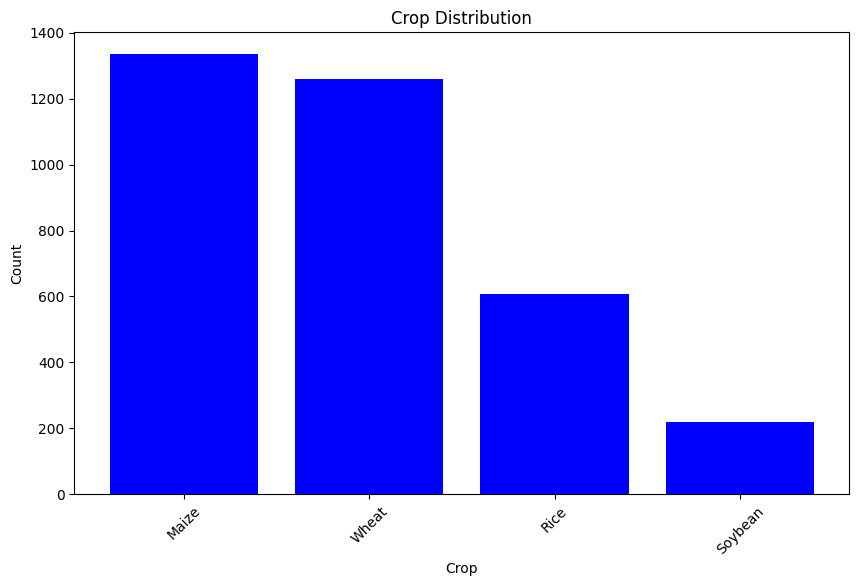

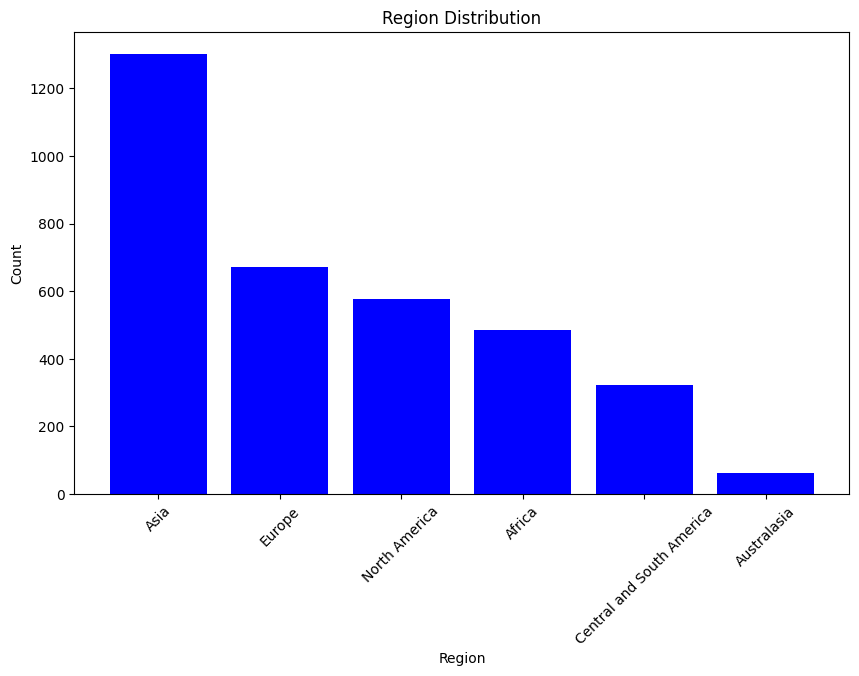

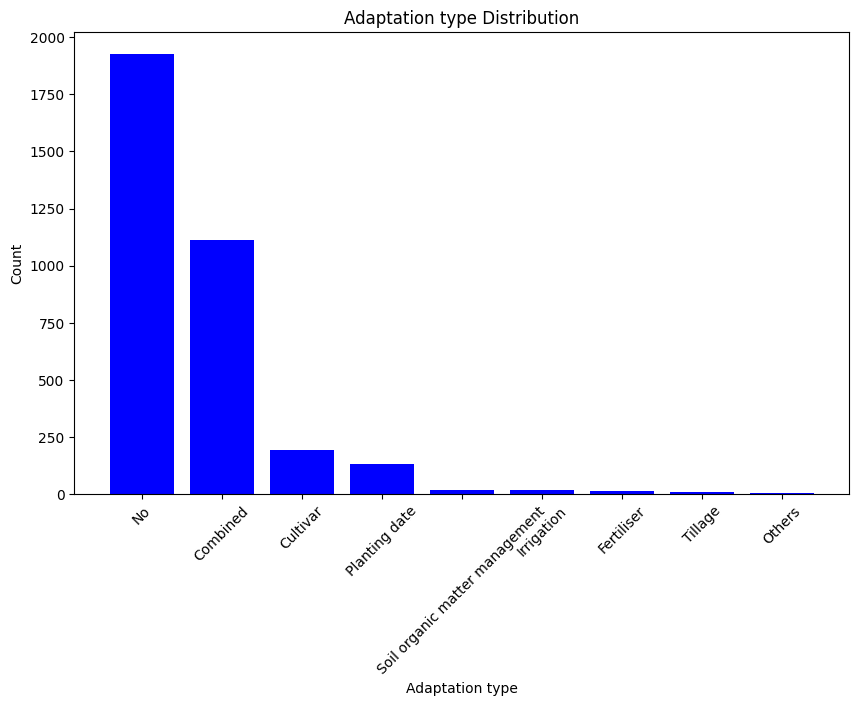

In [24]:
categorical_columns = ['Crop', 'Region', 'Adaptation type']

# Create bar charts for each categorical column
for column in categorical_columns:
    # Count the frequency of each category in the column
    category_counts = data[column].value_counts()
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.index, category_counts.values, color='blue')
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

##These bar charts display the distribution of categories within specific columns such as 'Crop,' 'Region,' and 'Adaptation type.' Each bar represents a category, and its height represents the count of occurrences. These visualizations provide insights into the composition and frequency of different categories in the dataset.

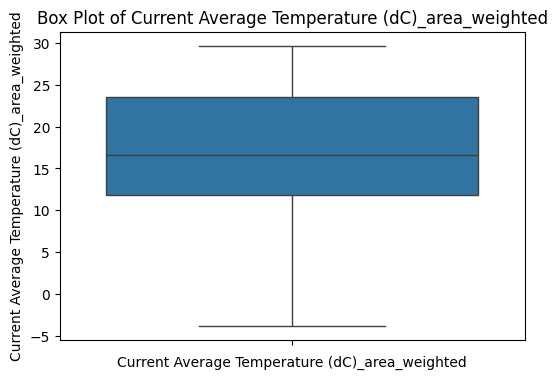

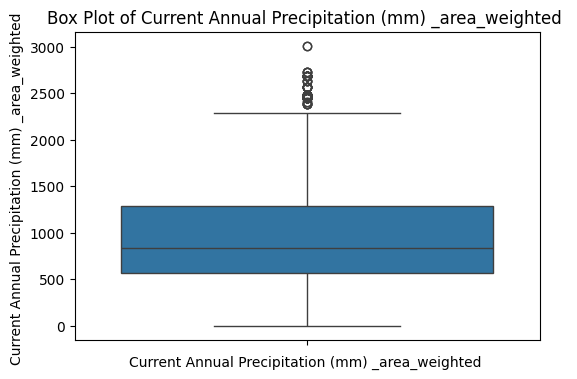

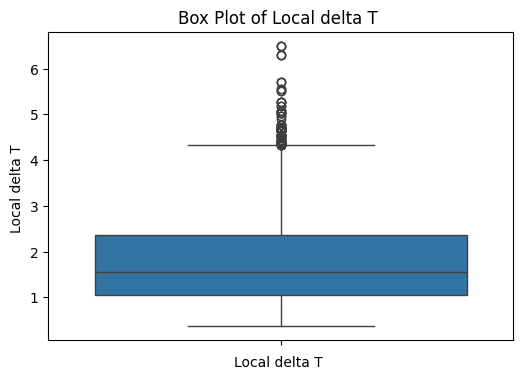

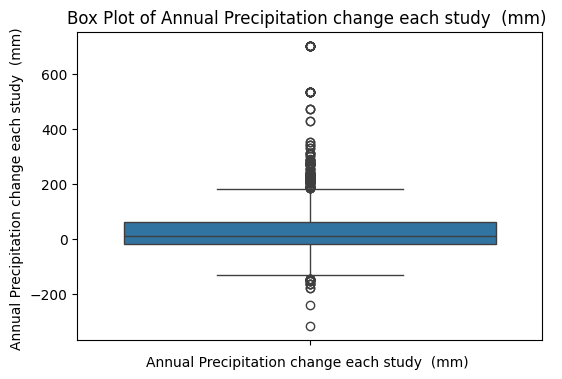

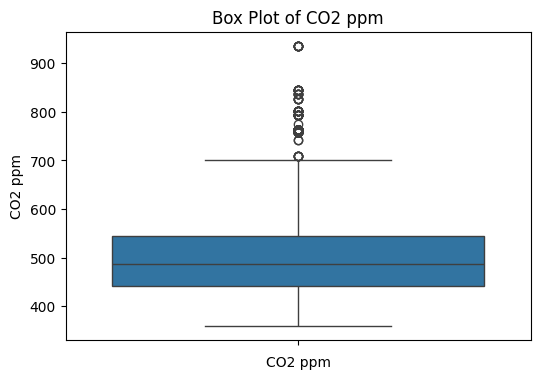

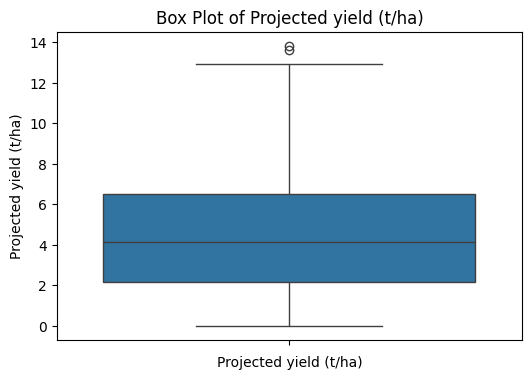

In [25]:
# Storing all the numeric columns name
numeric_column = [
    'Current Average Temperature (dC)_area_weighted',
    'Current Annual Precipitation (mm) _area_weighted ',
    'Local delta T ',
    'Annual Precipitation change each study  (mm) ',
    'CO2 ppm',
    'Projected yield (t/ha)'
]
# box plot
for num_col in numeric_column:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data[num_col])
    plt.title(f'Box Plot of {num_col}')
    plt.xlabel(num_col)
    plt.show()


##These box plots visualize the distribution of numeric data for various attributes such as temperature, precipitation, CO2 levels, and crop yield.Each box plot provides insights into the data's central tendency, spread, and the presence of outliers, helping us understand the characteristics of these numerical features.

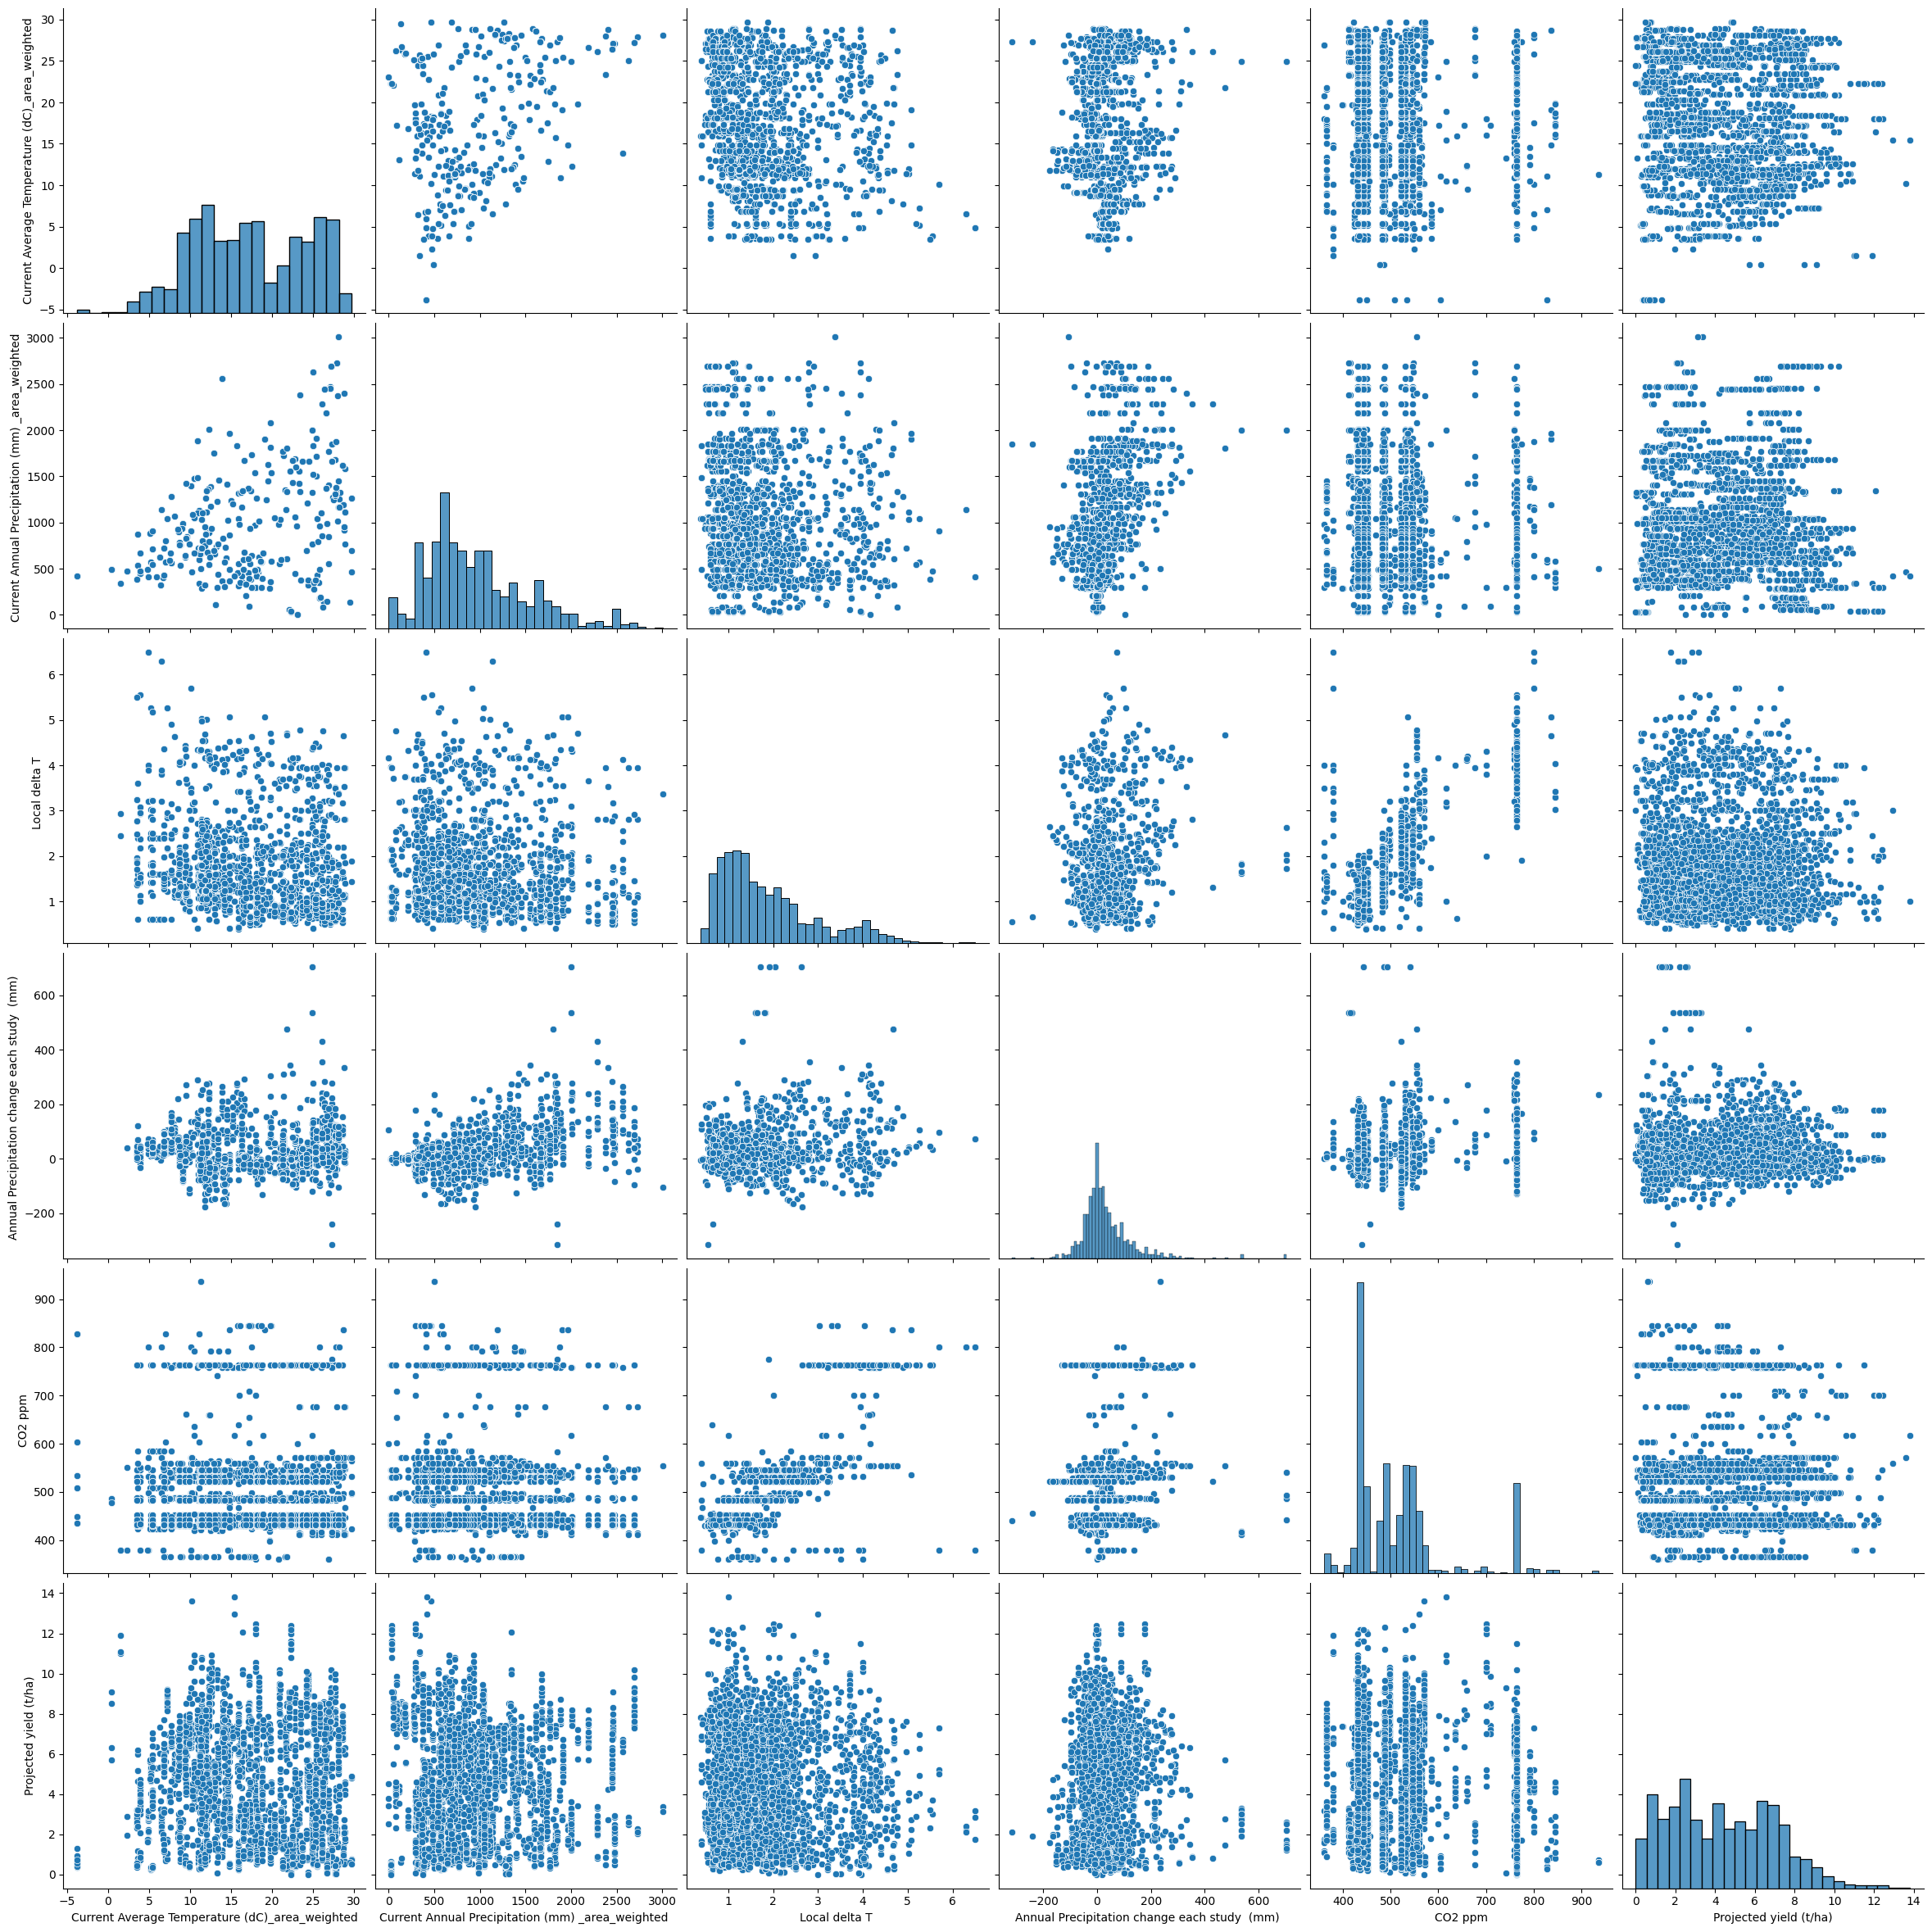

In [26]:
# Create a pair plot
sns.pairplot(data[numeric_column], height=4)
plt.show()

##This pair plot visually explores the relationships between different numeric attributes in the dataset. Each scatterplot in the matrix represents a pair of variables, allowing us to observe how they interact and if there are any correlations between them. It's a useful for understanding the data's feature interactions.

In [28]:
# Displaying the coorelationship
# correlation_matrix = data.corr()
# plt.figure(figsize=(8, 6))
# plt.title('Correlation Heatmap')
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.show()

##This correlation heatmap visually represents the relationships between different numeric attributes in the dataset. Each cell's color intensity and numerical value show the strength and direction of the correlations between the variables. By assisting in feature selection and data exploration, it enables us to find patterns and dependencies in the data.

### Handling Missing Value

In [29]:
# Count the number of null value present in dataframe
null_counts = [spark_sum(col(column).isNull().cast("int")).alias(column) for column in columns]
# Calculate the number of null values
null_counts_result = dataframe.select(null_counts)
# Show the result
null_counts_result.show()

+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
|Crop|Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+--

In [30]:
missingValue = ['Local delta T ','Annual Precipitation change each study  (mm) ','CO2 ppm']
for column in missingValue:
  dataframe = dataframe.withColumn(column, F.first(column, ignorenulls=True).over(Window.orderBy(F.monotonically_increasing_id())))
  dataframe = dataframe.withColumn(column, F.last(column, ignorenulls=True).over(Window.orderBy(F.monotonically_increasing_id().desc())))
  dataframe = dataframe.withColumn(column, F.when(col(column).isNotNull(), col(column)).otherwise(
      ((F.lag(col(column)).over(Window.orderBy(F.monotonically_increasing_id())) +
        F.lead(col(column)).over(Window.orderBy(F.monotonically_increasing_id()))) / 2)
  ))
# Show the updated DataFrame
dataframe.show()

+-----+--------------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
| Crop|              Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+-----+--------------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+--------

##This figure consists of pairs of box plots for three columns: 'Local delta T,' 'Annual Precipitation change each study (mm),' and 'CO2 ppm.' The left box plot in each pair represents the original data distribution ('Old Distribution'), while the right box plot represents the distribution after handling missing values ('New Distribution'). Comparing these pairs allows us to see how handling missing values has affected the data distribution in each column.

In [31]:
# Count the number of null value present in dataframe
null_counts = [spark_sum(col(column).isNull().cast("int")).alias(column) for column in columns]
# Calculate the number of null values
null_counts_result = dataframe.select(null_counts)
# Show the result
null_counts_result.show()

+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
|Crop|Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+----+------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+--

Looking for the duplicated value as it shown duplicate value but there is difference in Tillage due to changes on project yield as per our domain knowledge we will not remove this duplicate value

In [32]:
duplicate_rows = dataframe.dropDuplicates()
duplicate_rows.show(5)

+-----+--------------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+
| Crop|              Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2|CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type|Publication year|
+-----+--------------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+--------

In [33]:
summary = dataframe.describe()
summary.show()

+-------+-----+-------------+----------------------------------------------+-------------------------------------------------+------------------+---------------------------------------------+----------------------+-------------------+----+-----------------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+-----------------+
|summary| Crop|       Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |    Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)| CO2|          CO2 ppm|Fertiliser|Irrigation|Cultivar|Soil organic matter management|Planting time|Tillage|Adaptation|Adaptation type| Publication year|
+-------+-----+-------------+----------------------------------------------+-------------------------------------------------+------------------+---------------------------------------------+----------------------+------------

In [34]:
data = dataframe.toPandas()

<Axes: >

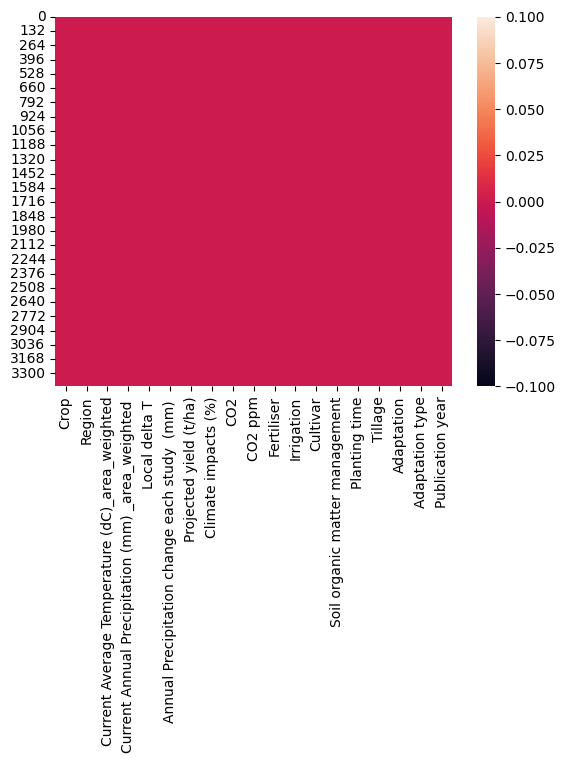

In [35]:
sns.heatmap(data.isnull())

##This heatmap visually represents missing (null) values in the dataset. Each white or distinct color square corresponds to a missing value in the dataset, while other colors represent non-missing values.

## One Hot encoding


In [36]:
#Create a new dataframe
new_data = dataframe.alias("new_data")

In [37]:
num_rows = new_data.count()
columns = new_data.columns
num_columns = len(columns)
print(f"Number of rows and columns is ({num_rows},{num_columns})")
print("Column names:", columns)

Number of rows and columns is (3420,19)
Column names: ['Crop', 'Region', 'Current Average Temperature (dC)_area_weighted', 'Current Annual Precipitation (mm) _area_weighted ', 'Local delta T ', 'Annual Precipitation change each study  (mm) ', 'Projected yield (t/ha)', 'Climate impacts (%)', 'CO2', 'CO2 ppm', 'Fertiliser', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage', 'Adaptation', 'Adaptation type', 'Publication year']


In [38]:
new_data_object_features = new_data.select(*[col(column) for column, dtype in new_data.dtypes if dtype == "string"])
# Get the count of rows (equivalent to shape[0] in Pandas)
row_count = new_data_object_features.count()
# Get the list of column names
column_names = new_data_object_features.columns
# Print the results
print("Total number of Categorical rows:", row_count)
print("Categorical features names:", column_names)

Total number of Categorical rows: 3420
Categorical features names: ['Crop', 'Region', 'CO2', 'Fertiliser', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage', 'Adaptation', 'Adaptation type']


In [39]:
# Select the string column
new_data_object_features = dataframe.select(*[col(column) for column, dtype in dataframe.dtypes if dtype == "string"])
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = new_data_object_features.toPandas()
# Print the unique value of string columns
for column in pandas_df.columns:
    unique_values = pandas_df[column].unique()
    print(f"{column}:\n{unique_values}")

Crop:
['Maize' 'Rice' 'Soybean' 'Wheat']
Region:
['Asia' 'North America' 'Africa' 'Central and South America' 'Europe'
 'Australasia']
CO2:
['Yes' 'No']
Fertiliser:
['No' 'Yes']
Irrigation:
['No' 'Yes']
Cultivar:
['No' 'Yes']
Soil organic matter management:
['No' 'Yes']
Planting time:
['No' 'Yes']
Tillage:
['No' 'Yes']
Adaptation:
['No' 'Yes']
Adaptation type:
['No' 'Combined' 'Others' 'Planting date' 'Tillage' 'Fertiliser'
 'Cultivar' 'Soil organic matter management' 'Irrigation']


In [40]:
# Stroing the categorical data for one hot encoding
onehot_encoding_data = ['Region', 'Crop', 'CO2', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage','Fertiliser','Adaptation type','Adaptation']
# Creating the list to hold the pipeline
stages = []
# Iterate the all the columns present in onehot_encoding data
for column in onehot_encoding_data:
    # Convert the catagory into string
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    stages.append(indexer)
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_encoded")
    stages.append(encoder)
pipeline = Pipeline(stages=stages)
# Data fit and transform
model = pipeline.fit(dataframe)
df_encoded = model.transform(dataframe)
# show the data
df_encoded.show()

+-----+--------------------+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+---+-------+----------+----------+--------+------------------------------+-------------+-------+----------+---------------+----------------+------------+--------------+----------+-------------+---------+-------------+----------------+------------------+--------------+----------------+------------------------------------+--------------------------------------+-------------------+---------------------+-------------+---------------+----------------+------------------+---------------------+-----------------------+----------------+------------------+
| Crop|              Region|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate im

In [41]:
# Define the columns to drop
columns_to_drop = ['Region', 'Crop', 'CO2', 'Irrigation', 'Cultivar', 'Soil organic matter management',
                   'Planting time', 'Tillage', 'Fertiliser', 'Adaptation type', 'Adaptation']

# Select the columns you want to keep (drop the specified columns)
df_without_columns = df_encoded.select([col for col in df_encoded.columns if col not in columns_to_drop])

# Show the df_encoded without the dropped columns
df_without_columns.show()

+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+-------+----------------+------------+--------------+----------+-------------+---------+-------------+----------------+------------------+--------------+----------------+------------------------------------+--------------------------------------+-------------------+---------------------+-------------+---------------+----------------+------------------+---------------------+-----------------------+----------------+------------------+
|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2 ppm|Publication year|Region_index|Region_encoded|Crop_index| Crop_encoded|CO2_index|  CO2_encoded|Irrigation_index|Irrigation_encoded|Cultivar_index|Cultiv

In [42]:
df_without_columns.printSchema()

root
 |-- Current Average Temperature (dC)_area_weighted: double (nullable = true)
 |-- Current Annual Precipitation (mm) _area_weighted : double (nullable = true)
 |-- Local delta T : double (nullable = true)
 |-- Annual Precipitation change each study  (mm) : double (nullable = true)
 |-- Projected yield (t/ha): double (nullable = true)
 |-- Climate impacts (%): double (nullable = true)
 |-- CO2 ppm: double (nullable = true)
 |-- Publication year: integer (nullable = true)
 |-- Region_index: double (nullable = false)
 |-- Region_encoded: vector (nullable = true)
 |-- Crop_index: double (nullable = false)
 |-- Crop_encoded: vector (nullable = true)
 |-- CO2_index: double (nullable = false)
 |-- CO2_encoded: vector (nullable = true)
 |-- Irrigation_index: double (nullable = false)
 |-- Irrigation_encoded: vector (nullable = true)
 |-- Cultivar_index: double (nullable = false)
 |-- Cultivar_encoded: vector (nullable = true)
 |-- Soil organic matter management_index: double (nullable = f

## Split Data in Training and Testing

In [43]:
X = df_without_columns.drop('Projected yield (t/ha)')
y = df_without_columns.select('Projected yield (t/ha)')

X.show()
y.show()

+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+-------------------+-------+----------------+------------+--------------+----------+-------------+---------+-------------+----------------+------------------+--------------+----------------+------------------------------------+--------------------------------------+-------------------+---------------------+-------------+---------------+----------------+------------------+---------------------+-----------------------+----------------+------------------+
|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Climate impacts (%)|CO2 ppm|Publication year|Region_index|Region_encoded|Crop_index| Crop_encoded|CO2_index|  CO2_encoded|Irrigation_index|Irrigation_encoded|Cultivar_index|Cultivar_encoded|Soil organic matter management_inde

In [44]:
# # Split the data into training and testing sets
train_data, test_data = df_without_columns.randomSplit([0.8, 0.2], seed=42)
# Display the size of training and testing
print("X_train count:", train_data.count())
print("X_test count:", test_data.count())

X_train count: 2784
X_test count: 636


In [46]:
# X_train = train_data.select('Features')
# y_train = train_data.select('Projected yield (t/ha)')
# X_test = test_data.select('Features')
# y_test = test_data.select('Projected yield (t/ha)')
# Define the feature columns (excluding the target variable)
feature_columns = [col for col in train_data.columns if col != 'Projected yield (t/ha)']

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='Features')

# Transform the train and test data using the assembler
X_train = assembler.transform(train_data).select('Features')
X_test = assembler.transform(test_data).select('Features')

# Select the target variable
y_train = train_data.select('Projected yield (t/ha)')
y_test = test_data.select('Projected yield (t/ha)')

In [47]:
train_data.show()

+----------------------------------------------+-------------------------------------------------+--------------+---------------------------------------------+----------------------+-------------------+-------+----------------+------------+--------------+----------+-------------+---------+-------------+----------------+------------------+--------------+----------------+------------------------------------+--------------------------------------+-------------------+---------------------+-------------+---------------+----------------+------------------+---------------------+-----------------------+----------------+------------------+
|Current Average Temperature (dC)_area_weighted|Current Annual Precipitation (mm) _area_weighted |Local delta T |Annual Precipitation change each study  (mm) |Projected yield (t/ha)|Climate impacts (%)|CO2 ppm|Publication year|Region_index|Region_encoded|Crop_index| Crop_encoded|CO2_index|  CO2_encoded|Irrigation_index|Irrigation_encoded|Cultivar_index|Cultiv

## Train The model

In [48]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
# Exclute the project yield
feature_columns = [col_name for col_name in train_data.columns if col_name != 'Projected yield (t/ha)']
# Create a VectorAssembler to assemble the feature columns into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = vector_assembler.transform(train_data)
test_data = vector_assembler.transform(test_data)
# Create a LinearRegression
linear_reg_model = LinearRegression(featuresCol="features", labelCol="Projected yield (t/ha)")
# Fit the model of train_data
linear_reg_model = linear_reg_model.fit(train_data)
# Make prediction of test_data
predictions = linear_reg_model.transform(test_data)
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Projected yield (t/ha)", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
rmse_linear = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse_linear}")


Mean Squared Error: 4.460591336796173
R-squared: 0.4068657815664496
RMSE: 2.11201120659815


In [ ]:

y_test_list = y_test.select('Projected yield (t/ha)').rdd.flatMap(lambda x: x).collect()
y_pred_list = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create a Pandas DataFrame for plotting
scatter_data = pd.DataFrame({'Actual Yield': y_test_list, 'Predicted Yield': y_pred_list})

# Scatter plot
plt.scatter(scatter_data['Actual Yield'], scatter_data['Predicted Yield'], alpha=0.5)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs. Predicted Crop Yield Linear Regressor")
plt.grid(True)
plt.plot([min(scatter_data['Actual Yield']), max(scatter_data['Actual Yield'])],
         [min(scatter_data['Actual Yield']), max(scatter_data['Actual Yield'])],
         color='red', linestyle='--', linewidth=2)

# Show the plot
plt.show()



##This scatter plot compares the actual crop yield values with the predicted values generated by a machine learning model (Random Forest). Each point represents a crop yield observation. The diagonal red dashed line serves as a reference for perfect predictions, where points should align.

In [ ]:
import xgboost as xgb
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
rf = RandomForestRegressor(featuresCol="features", labelCol="Projected yield (t/ha)", numTrees=100, seed=42)
rf_model = rf.fit(train_data)
#Prediction of test data
predictions_rf = rf_model.transform(test_data)
# Module evaluate
evaluator_rf = RegressionEvaluator(labelCol="Projected yield (t/ha)", predictionCol="prediction", metricName="mse")
mse_rf = evaluator_rf.evaluate(predictions_rf)
evaluator_rf = RegressionEvaluator(labelCol="Projected yield (t/ha)", predictionCol="prediction", metricName="r2")
r2_rf = evaluator_rf.evaluate(predictions_rf)
# RMSE calucuate
rmse_rf = mse_rf ** 0.5
print("Random Forest Mean Squared Error: {:.2f}".format(mse_rf))
print("Random Forest R-squared: {:.2f}".format(r2_rf))
print("Random Forest RMSE: {:.2f}".format(rmse_rf))

In [ ]:
import pandas as pd
# Collect the predicted and actual values
y_test_list = y_test.select('Projected yield (t/ha)').rdd.flatMap(lambda x: x).collect()
y_pred_list = predictions_rf.select('prediction').rdd.flatMap(lambda x: x).collect()
# Create a Pandas DataFrame for plotting
scatter_data = pd.DataFrame({'Actual Yield': y_test_list, 'Predicted Yield': y_pred_list})
# Display scatter plot
plt.scatter(scatter_data['Actual Yield'], scatter_data['Predicted Yield'], alpha=0.5)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs. Predicted Crop Yield (Random Forest)")
plt.grid(True)
plt.plot([min(scatter_data['Actual Yield']), max(scatter_data['Actual Yield'])],
         [min(scatter_data['Actual Yield']), max(scatter_data['Actual Yield'])],
         color='red', linestyle='--', linewidth=2)
# Show the plot
plt.show()



##This scatter plot compares the actual crop yield values with the predicted values generated by a Random Forest regression model. Each point represents a crop yield observation. The diagonal red dashed line serves as a reference for perfect predictions, where points should align.

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
# Extract NumPy arrays from the Vector column
X_train_np = np.array(train_data.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_train_np = np.array(train_data.select("Projected yield (t/ha)").rdd.flatMap(lambda x: x).collect())
X_test_np = np.array(test_data.select("features").rdd.map(lambda x: x[0].toArray()).collect())
# Initialize and fit an XGBoost regression model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_np, y_train_np)
# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_np)
# Calculate Mean Squared Error, R-squared, and RMSE
mse_xgb = mean_squared_error(test_data.select("Projected yield (t/ha)").rdd.flatMap(lambda x: x).collect(), y_pred_xgb)
r2_xgb = r2_score(test_data.select("Projected yield (t/ha)").rdd.flatMap(lambda x: x).collect(), y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Mean Squared Error: {:.2f}".format(mse_xgb))
print("XGBoost R-squared: {:.2f}".format(r2_xgb))
print("XGBoost RMSE: {:.2f}".format(rmse_xgb))


In [ ]:
y_test_values = [row["Projected yield (t/ha)"] for row in y_test.collect()]
# Create a scatter plot
plt.scatter(y_test_values, y_pred_xgb, alpha=0.5)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs. Predicted Crop Yield (XGBoost)")
plt.grid(True)
# Add a reference line (diagonal line)
plt.plot([min(y_test_values), max(y_test_values)], [min(y_test_values), max(y_test_values)], color='red', linestyle='--', linewidth=2)
# Show the plot
plt.show()



In [ ]:
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mse_values = [r2, r2_rf, r2_xgb]
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (RMSE)')
plt.title('Comparison of MSE for Different Models')
plt.ylim([0, max(mse_values) + 0.1])  # Set the y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
spark.stop()